In [1]:
from Main import prepare_experiment, run_experiment
from Parser import parse_dataset, generate_embeddings
from GraphGeneration import generate_graphs

dataset_name = 'Windows'
root_path = '/home/ubuntu/bsc/BootDet/Log2Graph'

In [4]:
st = 0.4
depth = 5

parse_dataset(dataset_name, st, depth)

Parsing file: /home/ubuntu/bsc/BootDet/Log2Graph/Data/Windows/Windows.log
Total lines:  19617
Processed 5.1% of log lines.
Processed 10.2% of log lines.
Processed 15.3% of log lines.
Processed 20.4% of log lines.
Processed 25.5% of log lines.
Processed 30.6% of log lines.
Processed 35.7% of log lines.
Processed 40.8% of log lines.
Processed 45.9% of log lines.
Processed 51.0% of log lines.
Processed 56.1% of log lines.
Processed 61.2% of log lines.
Processed 66.3% of log lines.
Processed 71.4% of log lines.
Processed 76.5% of log lines.
Processed 81.6% of log lines.
Processed 86.7% of log lines.
Processed 91.8% of log lines.
Processed 96.9% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:08.632985]


In [5]:
generate_embeddings(dataset_name)

Loaded 66 templates from /home/ubuntu/bsc/BootDet/Log2Graph/Data/Windows/Windows.log_templates.csv
Loaded GloVe embeddings. (50D)
TF-IDF model fitted on all templates.
Saved embeddings for 66 templates to /home/ubuntu/bsc/BootDet/Log2Graph/Data/Gloves/Results/Windows_embeddings.json


In [6]:
generate_graphs(dataset_name)

100%|██████████| 210/210 [00:05<00:00, 40.86it/s]

Saved GraphIndex → GroupId mapping to /home/ubuntu/bsc/BootDet/Log2Graph/Data/Windows/graph_ids.csv


In [2]:
data_seed = 1213
model_seed = 0
num_layers = 2
aggregation = 'Mean' # Readout function
hidden_dim = 64
lr = 0.001
weight_decay = 0.0001
batch = 64
device = 0
epochs = 150
hpo = False


prepare_experiment(dataset_name)

important_epoch_info, epoch_info, my_test, *_ = run_experiment(
    data=dataset_name, 
    data_seed=data_seed, 
    model_seed=model_seed, 
    num_layers=num_layers, 
    aggregation=aggregation, 
    hidden_dim=hidden_dim, 
    lr=lr, 
    weight_decay=weight_decay, 
    batch=batch, 
    device=device, 
    epochs=epochs, 
    hpo=hpo
    )

Processing...
Done!
100%|██████████| 151/151 [00:07<00:00, 19.05it/s]


Best epoch (by val_loss): 10
  train_loss = 0.000500
  val_loss   = 0.000372
  ROC-AUC    = 0.967, AP = 0.938


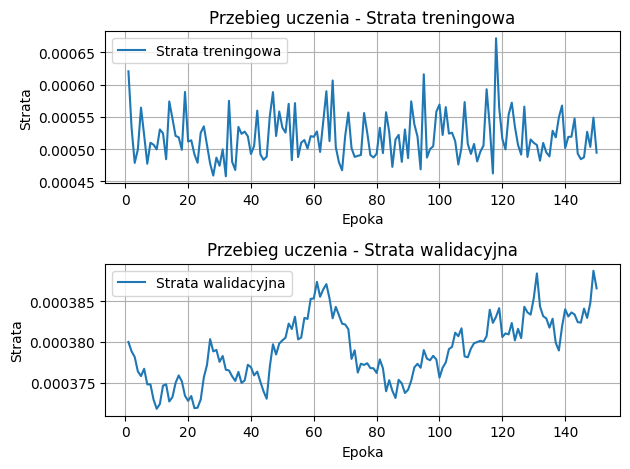

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay

t_loss = [epoch_info.train_loss for epoch_info in epoch_info]
v_loss = [epoch_info.val_loss for epoch_info in epoch_info]
tl = t_loss[1:]
vl = v_loss[1:]

fig, axs = plt.subplots(2)

epochs = range(1, len(t_loss))
axs[0].plot(epochs, tl, label="Strata treningowa")
axs[1].plot(epochs, vl, label="Strata walidacyjna")
axs[0].set_xlabel("Epoka")
axs[0].set_ylabel("Strata")
axs[1].set_xlabel("Epoka")
axs[1].set_ylabel("Strata")
axs[0].set_title("Przebieg uczenia - Strata treningowa")
axs[1].set_title("Przebieg uczenia - Strata walidacyjna")
axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
plt.show()

Liczba próbek do ewaluacji: 27
Liczba anomalii: 7


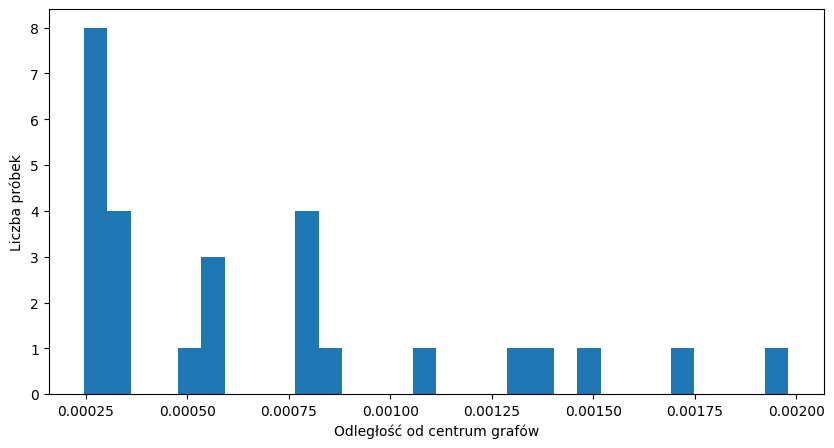

Best threshold = 0.00058953
==== METRYKI ====
Threshold           = 0.00058953
ROC-AUC             = 0.9429
Average Precision   = 0.8766   (PR-AUC)
Precision (thr)     = 0.6364
Recall (thr)        = 1.0000
F1-Score (thr)      = 0.7778


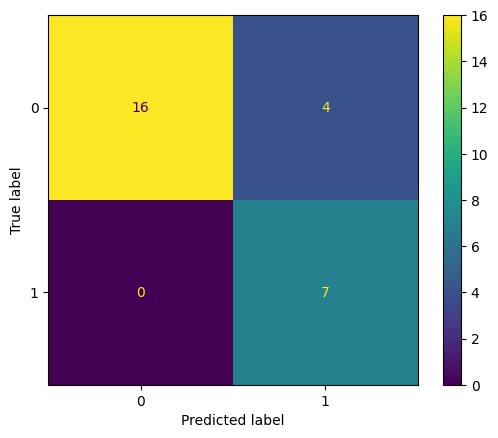

In [10]:

scores = important_epoch_info['svdd'].dists

scores_np = scores.cpu().numpy()

result = {
    my_test[idx].boot_id: float(scores_np[idx])
    for idx in np.argsort(scores_np)[::-1]   # descending
}

result_df = pd.DataFrame(result.items(), columns=['BootId', 'AnomalyScore'])

df_labels = pd.read_csv(f"{root_path}/Data/BSC/anomaly_label.csv")
df_labels = df_labels.rename(columns={"GroupId": "BootId"})

merged = pd.merge(result_df, df_labels, on='BootId')

y_true = merged['Label'].apply(lambda x: 1 if x == 'Anomaly' else 0).values.astype(int)
y_score = merged["AnomalyScore"].values.astype(float)

print("Liczba próbek do ewaluacji:", len(y_true))
print("Liczba anomalii:", y_true.sum())

plt.figure(figsize=(10,5))
plt.hist(scores_np, bins=30)
plt.xlabel("Odległość od centrum grafów")
plt.ylabel("Liczba próbek")
plt.show()

num_thr = 500
thr_values = np.linspace(y_score.min(), y_score.max(), num_thr)

best_f1 = -1.0
best_thr = None
best_prec = None
best_rec = None
best_cm = None

for thr in thr_values:
    y_pred = (y_score > thr).astype(int)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
        best_prec = precision_score(y_true, y_pred, zero_division=0)
        best_rec = recall_score(y_true, y_pred, zero_division=0)
        best_cm = confusion_matrix(y_true, y_pred)

print(f"Best threshold = {best_thr:.8f}")


thr = best_thr

# Predykcje
y_pred = (y_score > thr).astype(int)

# Podstawowe metryki
roc_auc = roc_auc_score(y_true, y_score)
ap = average_precision_score(y_true, y_score)

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("==== METRYKI ====")
print(f"Threshold           = {thr:.8f}")
print(f"ROC-AUC             = {roc_auc:.4f}")
print(f"Average Precision   = {ap:.4f}   (PR-AUC)")
print(f"Precision (thr)     = {precision:.4f}")
print(f"Recall (thr)        = {recall:.4f}")
print(f"F1-Score (thr)      = {f1:.4f}")

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()